### Scrap Data (News articles) from GDELT

In [ ]:
import gdelt

# Version 1 queries
gd1 = gdelt.gdelt(version=1)

# pull single day, gkg table
df1= gd1.Search(['2024 March 25','2024 March 27'],coverage=True,table='gkg')
df1.shape

In [ ]:
df2.to_excel ("gdelt_March28-30_2024.xlsx")

In [15]:
import pandas as pd
df2=pd.read_excel("gdelt_March28-30_2024.xlsx",index_col=0)

In [16]:
df2.shape

(213934, 5)

In [17]:
df2.columns

Index(['DATE', 'THEMES', 'LOCATIONS', 'TONE', 'SOURCEURLS'], dtype='object')

In [18]:
df2.head()

,DATE,THEMES,LOCATIONS,TONE,SOURCEURLS
1,20240329,TAX_FNCACT;TAX_FNCACT_NOMINEES;MEDIA_SOCIAL;TA...,"1#Ghana#GH#GH#8#-2#GH;4#Accra, Greater Accra, ...","1.52905198776758,5.19877675840979,3.6697247706...",https://www.modernghana.com/news/1302487/boga-...
2,20240329,WB_1920_FINANCIAL_SECTOR_DEVELOPMENT;WB_363_FI...,1#Poland#PL#PL#52#20#PL;1#Luxembourg#LU#LU#49....,"-2.85306704707561,1.85449358059914,4.707560627...",https://www.theregister.com/2024/03/29/amazon_...
3,20240329,TAX_ETHNICITY;TAX_ETHNICITY_BLACK;NATURAL_DISA...,"4#Waterloo, Ontario, Canada#CA#CA08#43.4667#-8...","-1.24792013311148,1.99667221297837,3.244592346...",https://www.salon.com/2024/03/28/orange-is-the...
4,20240329,LEADER;TAX_FNCACT;TAX_FNCACT_PRESIDENT;USPEC_P...,1#United States#US#US#39.828175#-98.5795#US;1#...,"0.835073068893529,4.38413361169102,3.549060542...",https://www.thedailybeast.com/newsmax-helps-do...
5,20240329,CRISISLEX_CRISISLEXREC;RECRUITMENT;TAX_FNCACT;...,"2#Connecticut, United States#US#USCT#41.5834#-...","0.504032258064516,3.32661290322581,2.822580645...",https://www.12news.com/article/news/nation-wor...


### Select sample articles to reduce the computational burden

In [ ]:
# Select 15k samples, 5k from each date value
selected_rows = pd.concat([df2[df2['DATE'] == '20240327'].head(5000),
                           df2[df2['DATE'] == '20240326'].head(5000),
                           df2[df2['DATE'] == '20240325'].head(5000)])

# Display the selected rows
#selected_rows.to_excel ("gdelt_March28-30_2024_15k.xlsx")
print(selected_rows.shape)
selected_rows.head()

### Extract news texts and titles  from SOURCEURLS

In [ ]:
import pandas as pd
import newspaper
from newspaper import news_pool
from tqdm import tqdm

df = pd.read_excel('gdelt_March28-30_2024_15k.xlsx')

# Define a function to extract text from URLs
def extract_text(url):
    try:
        article = newspaper.Article(url)
        article.download()
        article.parse()
        text = article.text.strip()
        return text, 'Success'
    except Exception as e:
        print(f"Error fetching URL: {url}. Error: {str(e)}")
        return None, None

# Apply the function to the 'URL' column and store the text in a list
texts = []
for url in tqdm(df['SOURCEURLS'], desc="Extracting texts"):
    text, status = extract_text(url)
    texts.append(text)

# Add the texts list as a new column in the DataFrame
df['Text'] = texts

# Drop the "Unnamed: " column from the DataFrame
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]

# Remove rows with None values in the "Text" column
df = df.dropna(subset=['Text'])

# Print the number of articles extracted
print("Total number of articles extracted:", len(texts))
print("DataFrame shape:", df.shape)

# Display the DataFrame
df.head()

In [ ]:
#f.to_excel("gdelt_extracted_MR_08_2024.xlsx")
#df.to_csv ("GDELT_March_2024_10k_dataset.csv")

In [24]:
df3=pd.read_csv("GDELT_March_2024_10k_dataset.csv", index_col=0)

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 30)
print(df3.shape)
df3.head()

(8550, 4)


,DATE,SOURCEURLS,Title,Text
0,20240328,https://www.yahoo.com/news...,Rain and snow in Wisconsin...,"In the last week, heavy sn..."
1,20240328,https://www.washingtontime...,Youngkin vetoes Virginia b...,"RICHMOND, Va. — Republican..."
2,20240328,https://www.journal-news.c...,GDPR Support,logo_ddn_tag_Site JN with ...
4,20240328,https://www.winnipegfreepr...,Nigerian parents finally g...,"KADUNA, Nigeria (AP) — Par..."
5,20240328,https://godanriver.com/lif...,Taking the kids: Get ready...,Mark your calendars! There...


### Clustering Newspaper Articles from GDELT

### Import packages 

In [1]:
#pip install datasets sentence-transformers umap-learn hdbscan keybert
# manage data
from datasets import load_dataset
import pandas as pd

# embeddings
from sentence_transformers import SentenceTransformer

# dimensionality reduction
import umap

# clustering
import hdbscan

# extract keywords from texts
# used to assign meaningful names to clusters
from keybert import KeyBERT

# visualization
import plotly.express as px

/Users/adanetarekegn/anaconda3/envs/KG_ML/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
# download data
import pandas as pd
df=pd.read_csv("GDELT_March_2024_10k_dataset.csv",index_col=0) #Web scrapping articles 
print(df.shape)
df.head()

(8550, 4)


,DATE,SOURCEURLS,Title,Text
0,20240328,https://www.yahoo.com/news/rain-snow-wisconsin...,Rain and snow in Wisconsin offer some relief f...,"In the last week, heavy snow and rain througho..."
1,20240328,https://www.washingtontimes.com/news/2024/mar/...,Youngkin vetoes Virginia bills mandating minim...,"RICHMOND, Va. — Republican Virginia Gov. Glenn..."
2,20240328,https://www.journal-news.com/nation-world/a-ti...,GDPR Support,logo_ddn_tag_Site JN with Tagline logo-sns_tag...
4,20240328,https://www.winnipegfreepress.com/breakingnews...,Nigerian parents finally get a chance to see t...,"KADUNA, Nigeria (AP) — Parents of more than 13..."
5,20240328,https://godanriver.com/life-entertainment/nati...,Taking the kids: Get ready for the eclipse,Mark your calendars! There will be a rare sola...


The dataset contains 120k articles. Let’s keep only 3k of them to make computations faster in this project.

## Data Preprocesing

In [8]:
import re

# Convert text to lowercase, handling NaN values
df['Text'] = df.Text.apply(lambda x: x.lower() if pd.notna(x) else x)
# Remove numbers from the text, handling NaN values
df['Text'] = df.Text.apply(lambda x: re.sub(r'\d+', '', x) if pd.notna(x) else x)
# Remove punctuation from the text, handling NaN values
df['Text'] = df.Text.apply(lambda x: re.sub(r'[^\w\s]', ' ', x) if pd.notna(x) else x)
# Remove leading and trailing whitespaces, handling NaN values
df['Text'] = df.Text.apply(lambda x: x.strip() if pd.notna(x) else x)

In [10]:
def clean(raw):
    """ Remove hyperlinks and markup """
    # Check if text is not NaN
    if pd.notna(raw):
        result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
        #result= re.sub("[^a-zA-Z]","",str(result)) # Search for all non-letters  " ",   # Replace all non-letters with spaces
        result = re.sub('&gt;', "", result)
        result = re.sub('&#x27;', "'", result)
        result = re.sub('&quot;', '"', result)
        result = re.sub('&#x2F;', ' ', result)
        result = re.sub('<p>', ' ', result)
        result = re.sub('</i>', '', result)
        result = re.sub('&#62;', '', result)
        result = re.sub('<i>', ' ', result)
        result = re.sub("\n", '', result)
        result = re.sub("\t", '', result)
        return result
    else:
        return raw  # Return NaN value as is

# Apply the clean function to the 'Text' column
df['Text'] = df['Text'].apply(clean)

#### Remove non-English words

In [11]:
from langdetect import detect

# Assuming df is your DataFrame and 'Text' is the column containing text data

# Replace NaN values in the 'Text' column with an empty string
df["Text"] = df["Text"].fillna("")

# Filter rows with English text
def detect_language(text):
    try:
        if len(str(text)) < 3:  # Adjust the threshold as needed
            return "Too Short"
        return detect(str(text))
    except:
        return "Unknown"

df["Language"] = df["Text"].apply(detect_language)
df_filtered = df[df["Language"] == "en"]

In [12]:
print(df_filtered.shape)
df_filtered.head()

(8546, 5)


,DATE,SOURCEURLS,Title,Text,Language
0,20240328,https://www.yahoo.com/news/rain-snow-wisconsin...,Rain and snow in Wisconsin offer some relief f...,in the last week heavy snow and rain througho...,en
1,20240328,https://www.washingtontimes.com/news/2024/mar/...,Youngkin vetoes Virginia bills mandating minim...,richmond va republican virginia gov glenn...,en
2,20240328,https://www.journal-news.com/nation-world/a-ti...,GDPR Support,logo_ddn_tag_site jn with tagline logo sns_tag...,en
4,20240328,https://www.winnipegfreepress.com/breakingnews...,Nigerian parents finally get a chance to see t...,kaduna nigeria ap parents of more than n...,en
5,20240328,https://godanriver.com/life-entertainment/nati...,Taking the kids: Get ready for the eclipse,mark your calendars there will be a rare sola...,en


In [6]:
from keybert import KeyBERT

kw_model = KeyBERT()
# Retain the articles titles only for analysis
titles_list = df_filtered.Text.tolist()

# Process the documents and collect the results
titles_keys = kw_model.extract_keywords(titles_list)

# Add the results to df
df_filtered["titles_keys"] = titles_keys
df_filtered

/var/folders/hc/6bpq37ws21l5yz971qdnj9pm0000gp/T/ipykernel_29322/3669044749.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["titles_keys"] = titles_keys


,DATE,SOURCEURLS,Title,Text,Language,titles_keys
0,20240328,https://www.yahoo.com/news/rain-snow-wisconsin...,Rain and snow in Wisconsin offer some relief f...,"In the last week, heavy snow and rain througho...",en,"[(drought, 0.5093), (droughts, 0.4863), (wisco..."
1,20240328,https://www.washingtontimes.com/news/2024/mar/...,Youngkin vetoes Virginia bills mandating minim...,"RICHMOND, Va. — Republican Virginia Gov. Glenn...",en,"[(marijuana, 0.4246), (cannabis, 0.3914), (leg..."
2,20240328,https://www.journal-news.com/nation-world/a-ti...,GDPR Support,logo_ddn_tag_Site JN with Tagline logo-sns_tag...,en,"[(logo_ddn_tag_site, 0.771), (sns_tag_site, 0...."
4,20240328,https://www.winnipegfreepress.com/breakingnews...,Nigerian parents finally get a chance to see t...,"KADUNA, Nigeria (AP) — Parents of more than 13...",en,"[(kaduna, 0.5333), (nigeria, 0.464), (nigerian..."
5,20240328,https://godanriver.com/life-entertainment/nati...,Taking the kids: Get ready for the eclipse,Mark your calendars! There will be a rare sola...,en,"[(eclipse, 0.4705), (eclipses, 0.4633), (solar..."
...,...,...,...,...,...,...
9993,20240329,https://y105fm.com/ixp/669/p/hundreds-of-deadl...,Hundreds of Deadly Fentanyl Pills Seized in Bu...,"Rochester, MN (KROC-AM News)- Authorities seiz...",en,"[(fentanyl, 0.5046), (felony, 0.3475), (roches..."
9994,20240329,https://wtop.com/j-j-green-national/2024/03/pe...,Persistent rumor of Putin’s death elicits nonc...,"For months, rumors have swirled about Russian ...",en,"[(putin, 0.5455), (vladimir, 0.4975), (kgb, 0...."
9995,20240329,https://smdp.com/2024/03/29/wet-season-far-fro...,Wet season far from winding down with Easter w...,According to the National Weather Service fore...,en,"[(rainfall, 0.4809), (easter, 0.4095), (rain, ..."
9996,20240329,https://orcadian.co.uk/in-this-weeks-the-orcad...,In this week’s The Orcadian,featured news\n\nIn this week’s The Orcadian\n...,en,"[(orkney, 0.5747), (orcadian, 0.4933), (nhs, 0..."


### LLM for Keyword extraction

In [ ]:
import openai
from keybert.llm import OpenAI
from keybert import KeyLLM

In [ ]:
# Create your LLM
openai.api_key = "key"

prompt = """
Extract the keywords or the keyphrases that best describe the topic of the given text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! 
4. Do not repeat keywords or phrases!
"""
llm = OpenAI(model="gpt-4", prompt=prompt, chat=True)

# Load it in KeyLLM
kw_model = KeyLLM(llm)

titles_list = df_filtered.Text.tolist()
# Extract keywords
keywords = kw_model.extract_keywords(titles_list, check_vocab=True); keywords

# Add the results to df
df_filtered["kewords"] = keywords
time.sleep(30)

In [ ]:
# Save the data and the results to a file
df_filtered.to_csv("extracted_keys_file_keyLLM.csv", index=False)

In [8]:
# Take a look at the output
pd.set_option('display.max_colwidth', 20)
df_filtered.head()     

,DATE,SOURCEURLS,Title,Text,Language,titles_keys
0,20240328,https://www.yaho...,Rain and snow in...,In the last week...,en,"[(drought, 0.509..."
1,20240328,https://www.wash...,Youngkin vetoes ...,"RICHMOND, Va. — ...",en,"[(marijuana, 0.4..."
2,20240328,https://www.jour...,GDPR Support,logo_ddn_tag_Sit...,en,[(logo_ddn_tag_s...
4,20240328,https://www.winn...,Nigerian parents...,"KADUNA, Nigeria ...",en,"[(kaduna, 0.5333..."
5,20240328,https://godanriv...,Taking the kids:...,Mark your calend...,en,"[(eclipse, 0.470..."


In [9]:
import pandas as pd
import ast

# Create a column that records the number of keywords/keyphrases
df_filtered['keys_length'] = df_filtered['titles_keys'].apply(lambda x: len(x))
df_filtered.head() 

/var/folders/hc/6bpq37ws21l5yz971qdnj9pm0000gp/T/ipykernel_29322/848705784.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['keys_length'] = df_filtered['titles_keys'].apply(lambda x: len(x))


,DATE,SOURCEURLS,Title,Text,Language,titles_keys,keys_length
0,20240328,https://www.yaho...,Rain and snow in...,In the last week...,en,"[(drought, 0.509...",5
1,20240328,https://www.wash...,Youngkin vetoes ...,"RICHMOND, Va. — ...",en,"[(marijuana, 0.4...",5
2,20240328,https://www.jour...,GDPR Support,logo_ddn_tag_Sit...,en,[(logo_ddn_tag_s...,5
4,20240328,https://www.winn...,Nigerian parents...,"KADUNA, Nigeria ...",en,"[(kaduna, 0.5333...",5
5,20240328,https://godanriv...,Taking the kids:...,Mark your calend...,en,"[(eclipse, 0.470...",5


In [10]:
# Keep those titles that have 5 keywords/keyphrases only
df5 = df_filtered[df_filtered.keys_length == 5]

# Drop the 'keys_length' columns
df5.drop('keys_length', axis=1, inplace=True)

# Save the data to a csv file
df5.to_csv("parsed_5_keys_file.csv", index=False)

# Check for success
df5.head()

/var/folders/hc/6bpq37ws21l5yz971qdnj9pm0000gp/T/ipykernel_29322/583229821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.drop('keys_length', axis=1, inplace=True)


,DATE,SOURCEURLS,Title,Text,Language,titles_keys
0,20240328,https://www.yaho...,Rain and snow in...,In the last week...,en,"[(drought, 0.509..."
1,20240328,https://www.wash...,Youngkin vetoes ...,"RICHMOND, Va. — ...",en,"[(marijuana, 0.4..."
2,20240328,https://www.jour...,GDPR Support,logo_ddn_tag_Sit...,en,[(logo_ddn_tag_s...
4,20240328,https://www.winn...,Nigerian parents...,"KADUNA, Nigeria ...",en,"[(kaduna, 0.5333..."
5,20240328,https://godanriv...,Taking the kids:...,Mark your calend...,en,"[(eclipse, 0.470..."


In [11]:
# Create a list of all sublists of keywords and keyphrases
df5_keys = df5.titles_keys.tolist()

# Flatten the list of sublists
flat_keys = [item for sublist in df5_keys for item in sublist]

# Create a list of unique keywords
flat_keys = list(set(flat_keys))

# Create a dataframe with the distinct keywords
keys_df = pd.DataFrame(flat_keys, columns = ['key','score'])

# Count how many distinct keywords were extracted
keys_df.shape
     

(38000, 2)

In [12]:
# Display a sample of keywords or keyphrases
keys_df.head()     

,key,score
0,legalizing,0.3819
1,accident,0.2768
2,lightning,0.4698
3,undergraduate,0.4105
4,treks,0.2746


### LLM embedding: using text-embedding-ada-002

In [13]:
import os
import openai

# Set your OpenAI API key
openai.api_key = "key"
#  access the API key through os.environ
os.environ['OPENAI_API_KEY'] = openai.api_key


In [ ]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

keys_df['ada_embedding'] = keys_df.key.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
keys_df.to_csv('gdelt_title_text_with_LLM_embedding.csv', index=0) # save the embedding

In [15]:
import pandas as pd
keys_df=pd.read_csv("gdelt_title_text_with_LLM_embedding.csv") #Web scrapping articles 
print(keys_df.shape)
keys_df.head()

(18514, 3)


,key,score,ada_embedding
0,hyundai,0.4551,[-0.012657809071...
1,jailing,0.3627,[-0.023275019600...
2,nicknames,0.3657,[-0.032408613711...
3,currencies,0.3676,[-0.004608497489...
4,politician,0.3417,[-0.019050309434...


### Reduce Embeddings Size
To visualize the embeddings in two dimensions, let’s reduce their dimensions to 2 using **UMAP**. UMAP is rather sensible to its hyperparameters, so you can find in the code the hyperparameters that worked the best in my experiments.

In [17]:
import ast

# Convert string representations of lists to actual lists
keys_df['ada_embedding'] = keys_df['ada_embedding'].apply(ast.literal_eval)

# Use UMAP algorithm
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       metric='cosine').fit_transform(keys_df['ada_embedding'].tolist())
print(embeddings)

# Add the reduced embeddings to the dataframe
keys_df['key_umap'] = embeddings.tolist()

# Check the output
keys_df.head(2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[[4.7182918 3.5222564 4.606582  ... 4.3876157 3.3140616 5.6542034]
 [4.4845695 9.232697  4.199632  ... 4.6946945 8.123137  0.8492739]
 [4.973587  5.5024085 4.3777404 ... 3.4890957 6.6762137 3.197099 ]
 ...
 [5.5057464 7.314906  2.920752  ... 4.201762  7.575881  2.3602529]
 [4.328489  7.03189   3.0765023 ... 4.0939536 8.0007715 2.2900865]
 [4.2253003 5.095125  4.8381815 ... 3.082812  4.9797354 6.47529  ]]


,key,score,ada_embedding,key_umap
0,hyundai,0.4551,[-0.012657809071...,[4.7182917594909...
1,jailing,0.3627,[-0.023275019600...,[4.4845695495605...


In [19]:
keys_df.columns

Index(['key', 'score', 'ada_embedding', 'key_umap'], dtype='object')

### Elbow Method

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans
import numpy as np

In [21]:
df=keys_df.loc[:,['key', 'score', 'ada_embedding', 'key_umap']]

/Users/adanetarekegn/anaconda3/envs/KG_ML/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited at iteration 482 with accuracies 
[2.95567697e-15 3.23819082e-06 9.11127443e-06 6.90782466e-06]
not reaching the requested tolerance 7.078051567077637e-06.
Use iteration 482 instead with accuracy 
4.814322476861898e-06.

  _, diffusion_map = lobpcg(
/Users/adanetarekegn/anaconda3/envs/KG_ML/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited postprocessing with accuracies 
[1.94733235e-15 3.23819088e-06 9.11127470e-06 6.90782426e-06]
not reaching the requested tolerance 7.078051567077637e-06.
  _, diffusion_map = lobpcg(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

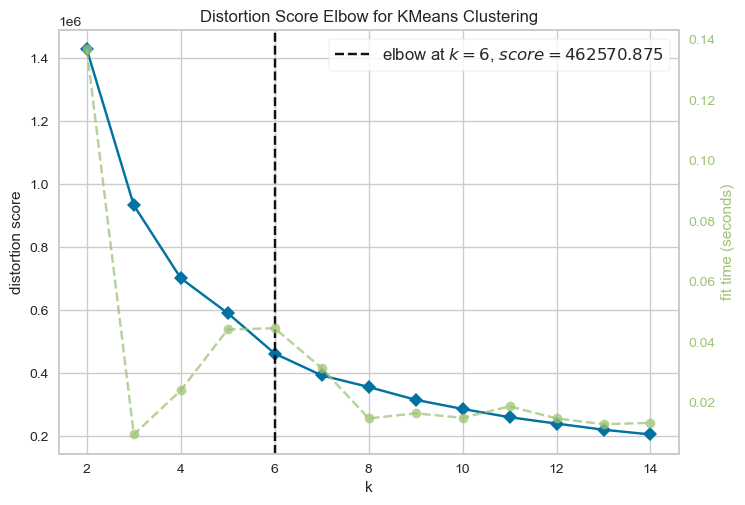

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# Elbow Method for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

# Convert to NumPy array
embedding_values_array = np.array(df["key_umap"].tolist())
    
# Reduce dimensionality using UMAP
umap_embedding = umap.UMAP().fit_transform(embedding_values_array)

model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,15), timings= True)
visualizer.fit(umap_embedding)        # Fit data to visualizer
visualizer.show()       # Finalize and render figure

### Generate clusters and Evaluate their Stability

In [23]:
from sklearn.model_selection import train_test_split

df1=keys_df.loc[:,['key', 'score', 'ada_embedding', 'key_umap']]
#X_train,X_test = train_test_split(X,test_size=0.25)
#X_train.shape, X_test.shape
#df1.head(1)

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
import prince
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import numpy as np

In [ ]:
#Intialize clustering and partitioning
kmeans = KMeans(n_clusters=6,init='k-means++', max_iter=300, n_init=10) 
cv = KFold(n_splits=6, random_state=42, shuffle=True)

counter=0
#Split data into 5 or 10 partitions
for train_index, test_index in cv.split(df1):
    X_train, X_test = df1.iloc[train_index], df1.iloc[test_index]
    
    # Convert strings representing lists to actual lists of floats (if required)
    X_train["key_umap"] = X_train["key_umap"].apply(lambda x: [float(val) for val in x.strip('][').split(', ')])
    X_test["key_umap"] = X_test["key_umap"].apply(lambda x: [float(val) for val in x.strip('][').split(', ')])

    #print(X_train.shape)
    # Take only the scores/features for both testing and training
    X_train= X_train[['key', 'score', 'ada_embedding', 'key_umap']]
    X_test= X_test[['key', 'score', 'ada_embedding', 'key_umap']]
    
    # Convert to NumPy array
    embedding_values_array = np.array(X_train["key_umap"].tolist())
    
    # Reduce dimensionality using UMAP
    umap_embedding = umap.UMAP().fit_transform(embedding_values_array)
   
    # Apply KMeans clustering with UMAP
    #kmeans = KMeans(n_clusters=5, random_state=0)  # You may adjust the number of clusters as needed
    labels = kmeans.fit_predict(umap_embedding)
    X_train["label"] = [str(label) for label in labels]
    #print(f"Num of clusters: {len(np.unique(labels))}")
    
    #Model fit with Testing data
    embedding_values_array_test = np.array(X_test["key_umap"].tolist())
    # Reduce dimensionality using UMAP
    umap_embedding_test = umap.UMAP().fit_transform(embedding_values_array_test)
    y_pred_test=kmeans.predict(umap_embedding_test)
    X_test["label"] = [str(label) for label in y_pred_test]
    #print(f"Num of clusters: {len(np.unique(labels))}")  

    # Calculate the sum of values in "key_umap" for each row
    X_train['sum_umap_train'] = X_train['key_umap'].apply(np.sum)
    X_test['sum_umap_train'] = X_test['key_umap'].apply(np.sum)
    
    # incude the sum of key_umap as new column
    Xtrain=X_train[['score','label', 'sum_umap_train']]
    Xtest=X_test[['score','label', 'sum_umap_train']]

    #Train :  group and sum values of each cluster on train
    Xtrain=Xtrain.groupby(['label']).sum()
    Xtrain2=Xtrain.T
    Xtrain2.columns=['c0', 'c1', 'c2', 'c3', 'c4','c5'];
    #Xtrain2.columns=['c0', 'c1', 'c2'];
    Xtrain3=Xtrain2.T
    
    # Test: group and sum values of each cluster  on test
    Xtest=Xtest.groupby(['label']).sum()
    Xtest2=Xtest.T
    Xtest2.columns=['c0', 'c1', 'c2','c3', 'c4','c5'];
    Xtest3=Xtest2.T

    #Total sum of clusters on train
    Xtrain3_sums = Xtrain3.sum(axis=0)
    
    # Train: Normalize values by dividing the values of each cluster by the total number 
    ct0=pd.Series(Xtrain3.iloc[0]/Xtrain3_sums)
    ct1=pd.Series(Xtrain3.iloc[1]/Xtrain3_sums)
    ct2=pd.Series(Xtrain3.iloc[2]/Xtrain3_sums)
    ct3=pd.Series(Xtrain3.iloc[3]/Xtrain3_sums)
    ct4=pd.Series(Xtrain3.iloc[4]/Xtrain3_sums)
    ct5=pd.Series(Xtrain3.iloc[5]/Xtrain3_sums)
 

    #Join clusters as columns and rename
    df_per_train=pd.concat([ct0,ct1,ct2,ct3,ct4,ct5],axis=1)
    df_per_train.columns = ['c0', 'c1', 'c2','c3', 'c4','c5']
    #df_per_test=df_per_train.T
    df_per_train

    #Total sum of clusters on Test
    Xtest3_sums = Xtest3.sum(axis=0)
    
    # # Test: Normalize values by dividing the values of each cluster by the total number 
    c00=pd.Series(Xtest3.iloc[0]/Xtest3_sums)
    c10=pd.Series(Xtest3.iloc[1]/Xtest3_sums)
    c20=pd.Series(Xtest3.iloc[2]/Xtest3_sums)
    c30=pd.Series(Xtest3.iloc[3]/Xtest3_sums)
    c40=pd.Series(Xtest3.iloc[4]/Xtest3_sums)
    c50=pd.Series(Xtest3.iloc[5]/Xtest3_sums)

    #Join clusters as columns and rename
    df_per_test=pd.concat([c00,c10,c20,c30,c40,c50],axis=1)
    df_per_test.columns = ['c0', 'c1', 'c2','c3','c4','c5']
    #df_per_test=df_per_train.T
    df_per_test

    # Define overall RMSE variable before the loop
    overall_rmse_per_cluster = []

    # Calculate RMSE for each partition/sample data
    
    for i in range(6):
        #train_df = train_dfs[i]
        #test_df = test_dfs[i]
        
        # Calculate the squared errors for each cluster in each partition
        squared_errors = (df_per_train.values) - (df_per_test.values) ** 2
        # Calculate the mean squared error for each cluster in each partition
        mean_squared_error = np.mean(squared_errors)
        # Calculate the root mean squared error (RMSE) for each cluster in each partition
        rmse_per_cluster = np.sqrt(mean_squared_error)
        #print(f"RMSE for partition {i+1} for each cluster:", rmse_per_cluster)
        # Append the RMSE for this partition to the overall RMSE list
        overall_rmse_per_cluster.append(rmse_per_cluster)
        
    print("Sample:",counter)
    print("Training set:",X_train.shape)
    print(f"Num of clusters: {len(np.unique(labels))}") 
    counter += 1
        
    # Convert the overall RMSE list to a numpy array
    overall_rmse_per_cluster = np.array(overall_rmse_per_cluster)
    
    # Calculate the overall RMSE by averaging the RMSEs of all clusters across all partitions
    overall_rmse = np.mean(overall_rmse_per_cluster)
    
    #print("\nOverall RMSE for each cluster:", [round(val, 4) for val in overall_rmse_per_cluster])
    print("\nOverall RMSE across all clusters and partitions:", round(overall_rmse, 4))